In [1]:
import os
import numpy as np
import pickle
import copy
from collections import OrderedDict
import matplotlib
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

In [2]:
dataset_name = "left_out_colored_mnist"
num_classes = 10
hold_out = False
model_name = "resnet_pretrained"
keep_pct = .9

if hold_out:
    data_type = "_hold_out"
else:
    data_type = ""
    
file_path = "../analysis/"+model_name+"/"
filename = "{}_{}_keep{}{}.pkl".format(model_name, dataset_name, int(100*keep_pct), data_type)
with open(file_path + filename,'rb') as f:
    activations_dict = pickle.load(f)
    
  

In [3]:
def plot_combination_acts(combo_matrix, neuron_idx_start, neuron_idx_end=None, normalize='individual'):
    col_size = 2
    if neuron_idx_end is not None:
        num_plots = neuron_idx_end - neuron_idx_start
        plot_IDs = [i for i in range(neuron_idx_start, neuron_idx_end)]
        fig, ax = plt.subplots(num_plots//col_size + (num_plots%col_size), col_size, sharey=False)

        for idx,i in enumerate(plot_IDs):
            if normalize == 'group':
                normalized_matrix = combo_matrix[i] / np.max(combo_matrix[neuron_idx_start: neuron_idx_end])
            elif normalize == 'individual':
                normalized_matrix = combo_matrix[i] / np.max(combo_matrix[i])
            else:
                normalized_matrix = combo_matrix[i][:]
                
            if num_plots > col_size:
                subplot_ax = ax[(idx)//col_size][idx%col_size]   
            else:
                subplot_ax = ax[idx]
                
            subplot_ax.set_xticks(np.arange(num_classes))
            subplot_ax.set_yticks(np.arange(num_classes))
            subplot_ax.title.set_text("neuron "+str(i))
            subplot_ax.imshow(normalized_matrix, aspect = 'auto')

            fig.set_size_inches(4*col_size,2*num_plots)
            
            
    else:
        normalized_matrix = combo_matrix[neuron_idx_start] / np.max(combo_matrix[neuron_idx_start])
        fig, ax = plt.subplots()
        ax.imshow(normalized_matrix)
        
        fig.set_size_inches(8,8)
    
    plt.show()
    
def plot_act_matrix(act_matrix, combinations_list, n_clusters=1):
    fig, ax = plt.subplots()
    out = act_matrix[:]
    
    if n_clusters > 1:
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(out.T)
        order = kmeans.labels_
        osort = order.argsort()
        out = out[:,osort[:]]
        sorted_order = order[osort[:]]
        
        xticks = np.array([])
        for i in range(n_clusters):
            to_append = np.where(sorted_order == i)
            xticks = np.append(xticks, to_append[0][0])
        
        ax.set_xticks(xticks)
        ax.set_xticklabels([n+1 for n in range(n_clusters)], fontsize=14)
        
        plt.xlabel("cluster")
    else:
        plt.xlabel("neuron index")
        
    plt.ylabel("combination")
    
    fig.set_size_inches(25,15)
    im = ax.imshow(out, aspect='auto')
    
    title = "Activations Plot for Combinations"
    
    plt.title(title)
    ax.set_yticks([i for i in range(len(combinations_list))])
    ax.set_yticklabels([str(c) for c in combinations_list], fontsize=11)
    
    plt.show()
        
        
        

In [12]:
combinations = [k for k in activations_dict]
sort_by_color = False
if sort_by_color:
    combinations.sort(key = lambda x: (x[1],x[0]))
else:
    combinations.sort()

num_neurons = activations_dict[[k for k in activations_dict][0]].shape[1]
neuron_combinations_mat = np.zeros((num_neurons, num_classes, num_classes))
acts_mat = np.zeros((len(combinations),num_neurons))
avg_acts_dict = {}


for idx,k in enumerate(combinations):
    avg_acts_dict[k] = np.mean(activations_dict[k],axis=0)
    neuron_combinations_mat[:,k[0],k[1]] = copy.deepcopy(avg_acts_dict[k]) 
    acts_mat[idx] = copy.deepcopy(avg_acts_dict[k])


normalized_acts_mat = acts_mat / np.max(acts_mat,axis=0)



<br><b>Individual Neuron Activation Plots</b> $x$-axis: Digit classification, $y$-axis: Color classification

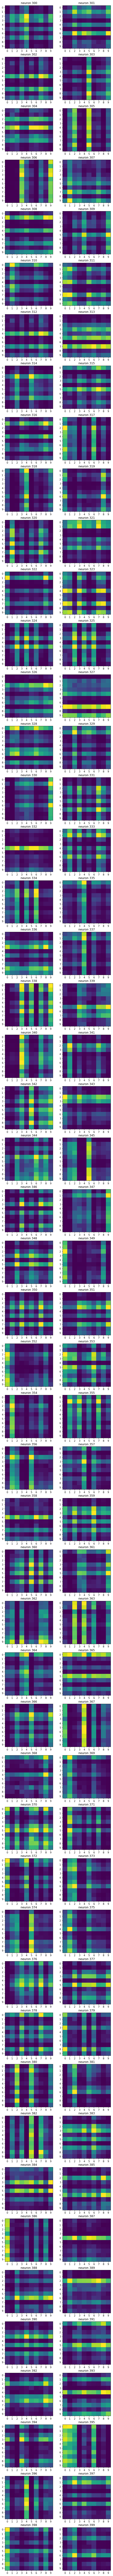

In [13]:
plot_combination_acts(neuron_combinations_mat, 300, 400, normalize="individual")





<br><b>Full Activation Plot</b> $y$-axis: target (digit,color), $x$-axis: neuron/cluster

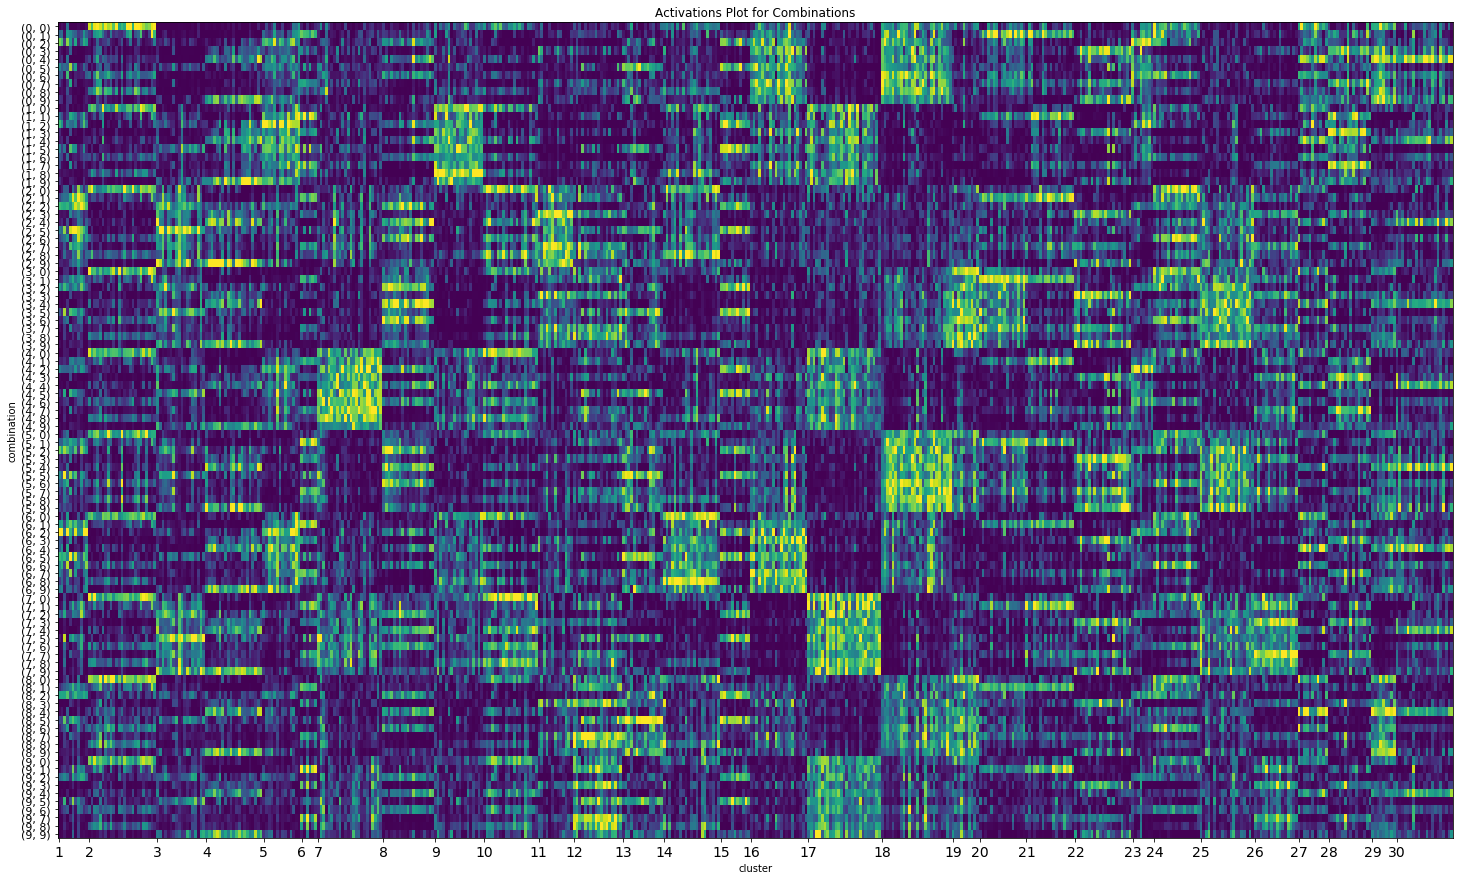

In [14]:
plot_act_matrix(act_matrix=normalized_acts_mat, combinations_list=combinations, n_clusters=30)

